# **Final Project: Face Mask Detector using Deep Learning** 
by Azadeh Ghaffari and Safoura Janosepah

**Objective** is to build a Deep Learning model which can identify if the person is wearing a mask or not, also detecting if people vilating social distancing norms.

The novel COVID-19 virus has forced us all to rethink how we live our everyday lives while keeping ourselves and others safe. Face masks have emerged as a simple and effective strategy for reducing the virus’s threat and also, application of face mask detection system are now in high demand for transportation means, densely populated areas, residential districts, large-scale manufacturers and other enterprises to ensure safety. Therefore, the goal of the today’s article is to develop a face mask detector using deep learning.

#**Table of Content**


1.   About Dataset
2.   Chosing Deep Learning Model
3.   Training and Evaluation of Models
4.   Experiments and Results
5.   Conclusion


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pkl
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
import cv2
import random

from plotly import graph_objects as go
from plotly import express as px
from xml.etree import ElementTree as et
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.models import Sequential
from keras.layers.experimental import preprocessing as ps
from keras.layers.experimental import preprocessing as ps
from keras.layers import Activation, Conv2D, BatchNormalization, Dense, Flatten, Dropout, MaxPooling2D
from keras.losses import CategoricalCrossentropy

from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from collections import defaultdict
from tensorflow.keras.applications import ResNet50,ResNet101,ResNet152,ResNet50V2,ResNet101V2,ResNet152V2

import os
os.environ["KAGGLE_CONFIG_DIR"]='/content'

##Download Data Face-Mask-Detection from Kaggle




### Preprocess Data 

In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [ ]:
os.listdir("/content/Face Mask Dataset/Train/")


['WithMask', 'WithoutMask']

In [ ]:
print("Images in Train Dataset:\n")
print("Number of Images for with Mask category:{}".format(len(os.listdir("/content/Face Mask Dataset/Train/WithMask"))))
print("Number of Images for with WithoutMask category:{}".format(len(os.listdir("/content/Face Mask Dataset/Train/WithoutMask/"))))

Images in Train Dataset:

Number of Images for with Mask category:5000
Number of Images for with WithoutMask category:5000


In [ ]:
train_dir = "/content/Face Mask Dataset/Train/"
test_dir = "/content/Face Mask Dataset/Test/"

### Images visualization

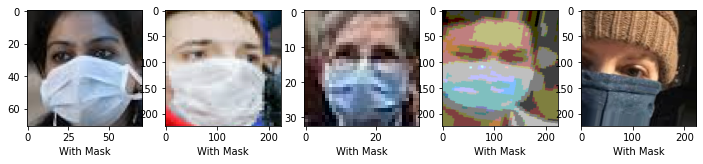

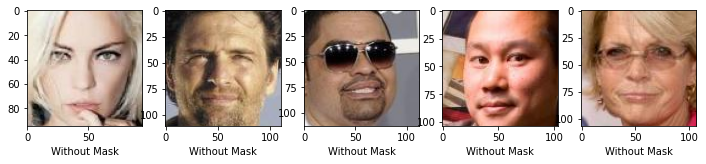

In [ ]:
#with Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(train_dir+"WithMask/"))
    plt.subplot(1,5,i+1)
    img = load_img(train_dir+"WithMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("With Mask")
    plt.imshow(img)
plt.show()

#without Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(train_dir+"WithoutMask/"))
    plt.subplot(1,5,i+1)
    img = load_img(train_dir+"WithoutMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("Without Mask")
    plt.imshow(img)
plt.show()

###Data Augmentation:

In [ ]:
height = 128
width=128
train_datagen = ImageDataGenerator(rescale=1.0/255,validation_split=0.2,shear_range = 0.2,zoom_range=0.2,horizontal_flip=True)
train = train_datagen.flow_from_directory(directory=train_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset = "training")

valid_datagen = ImageDataGenerator(rescale=1.0/255)

valid = train_datagen.flow_from_directory(directory=train_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset="validation")

test_datagen = ImageDataGenerator(rescale=1.0/255)

test= test_datagen.flow_from_directory(test_dir, target_size=(height,width), 
                                             batch_size=32, class_mode='categorical')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


### Building the Models 

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model1 = Sequential()
model1.add(vgg19)
model1.add(Flatten())
model1.add(Dense(2,activation='sigmoid'))
model1.summary()


80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


###Runnig the Model

In [ ]:
import time
start=time.perf_counter()
loss_acc_values=[]

model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

Checkpoints = ModelCheckpoint('model_mask.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min', save_freq='epoch')


Earlystop =EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 20,verbose = 1,
                                             restore_best_weights = True)
callbacks=[Earlystop,Checkpoints]
train_numbers=10000
valid_numbers=800
loss_acc_values.append(model1.fit_generator(generator=train,
                              steps_per_epoch=len(train)//32,
                              epochs=20,validation_data=valid,
                              validation_steps=len(valid)//32))

stop=time.perf_counter()

print('{:0.4f} mins elapsed'.format((stop-start)/60))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20
7/7 [==============================] - 20s 340ms/step - loss: 0.9459 - accuracy: 0.5046 - val_loss: 0.5550 - val_accuracy: 0.6250
Epoch 2/20
7/7 [==============================] - 2s 226ms/step - loss: 0.3855 - accuracy: 0.8276 - val_loss: 0.2272 - val_accuracy: 0.9375
Epoch 3/20
7/7 [==============================] - 2s 227ms/step - loss: 0.2378 - accuracy: 0.9215 - val_loss: 0.1354 - val_accuracy: 1.0000
Epoch 4/20
7/7 [==============================] - 2s 222ms/step - loss: 0.1582 - accuracy: 0.9596 - val_loss: 0.1629 - val_accuracy: 0.9375
Epoch 5/20
7/7 [==============================] - 2s 223ms/step - loss: 0.1408 - accuracy: 0.9553 - val_loss: 0.2691 - val_accuracy: 0.8750
Epoch 6/20
7/7 [==============================] - 2s 228ms/step - loss: 0.1449 - accuracy: 0.9399 - val_loss: 0.1140 - val_accuracy: 0.9688
Epoch 7/20
7/7 [==============================] - 2s 228ms/step - loss: 0.1454 - accuracy: 0.9410 - val_loss: 0.1485 - val_accuracy: 0.9062
Epoch 8/20
7/7 [===

Saving the Model

In [ ]:
model1.save('model_mask.h5')

### Integrating with haar cascade
After this, we intend to use it to detect if we are wearing a face mask using our PC’s webcam. For this, first, we need to implement face detection. In this, I am using the Haar Feature-based Cascade Classifiers for detecting the features of the face.

In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection
!unzip \*.zip && rm *.zip

 99% 393M/398M [00:05<00:00, 94.8MB/s]
100% 398M/398M [00:05<00:00, 72.2MB/s]
Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
 

In [ ]:
# 
!kaggle datasets download -d lalitharajesh/haarcascades
!unzip \*.zip && rm *.zip

  0% 0.00/1.45M [00:00<?, ?B/s]
100% 1.45M/1.45M [00:00<00:00, 99.9MB/s]
Archive:  haarcascades.zip
  inflating: haarcascade_eye.xml     
  inflating: haarcascade_eye_tree_eyeglasses.xml  
  inflating: haarcascade_frontalcatface.xml  
  inflating: haarcascade_frontalcatface_extended.xml  
  inflating: haarcascade_frontalface_alt.xml  
  inflating: haarcascade_frontalface_alt2.xml  
  inflating: haarcascade_frontalface_alt_tree.xml  
  inflating: haarcascade_frontalface_default.xml  
  inflating: haarcascade_fullbody.xml  
  inflating: haarcascade_lefteye_2splits.xml  
  inflating: haarcascade_licence_plate_rus_16stages.xml  
  inflating: haarcascade_lowerbody.xml  
  inflating: haarcascade_profileface.xml  
  inflating: haarcascade_righteye_2splits.xml  
  inflating: haarcascade_russian_plate_number.xml  
  inflating: haarcascade_smile.xml   
  inflating: haarcascade_upperbody.xml  


In [ ]:
faceCascade=cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

This cascade classifier is designed by OpenCV to detect the frontal face by training thousands of images. The .xml file for the same needs to be downloaded and used in detecting the face. I have uploaded the file in my GitHub repository.

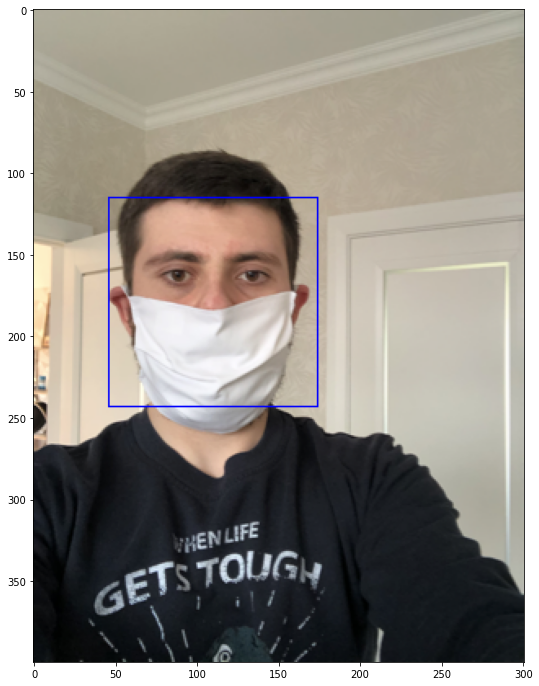

In [ ]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('/content/images/maksssksksss150.png')

gray = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = faceCascade.detectMultiScale(gray,1.3,5) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



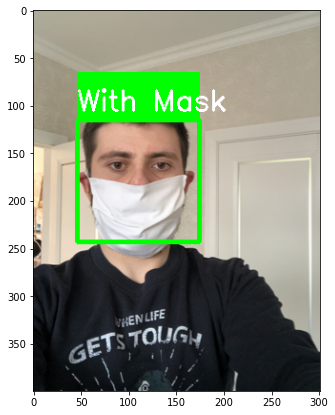

In [ ]:
mask = "/content/image/"
plt.figure(figsize=(8,7))
label = {0:"With Mask",1:"Without Mask"}
color_label = {0: (0,255,0),1 : (0,0,255)}
count = 0
i = "/content/images/maksssksksss150.png"

frame =cv2.imread(i)
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
faces =faceCascade.detectMultiScale(gray,1.3,5)
for x,y,w,h in faces:
    face_image = frame[y:y+h,x:x+w]
    resize_img  = cv2.resize(face_image,(height,width))
    normalized = resize_img/255.0
    reshape = np.reshape(normalized,(1,height,width,3))
    reshape = np.vstack([reshape])
    result = model1.predict_classes(reshape)
    
    if result == 0:
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[0],3)
        cv2.rectangle(frame,(x,y-50),(x+w,y),color_label[0],-1)
        cv2.putText(frame,label[0],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
    elif result == 1:
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[1],3)
        cv2.rectangle(frame,(x,y-50),(x+w,y),color_label[1],-1)
        cv2.putText(frame,label[1],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
    #plt.imshow(frame)
plt.show()
cv2.destroyAllWindows()

### Detecting the Faces with and without Masks

In [ ]:
import sys
test_dir="/content/Face Mask Dataset/Test"
def test_model(model):
    total_comparison=0
    total_incorrect=0
    class_list=list(train.class_indices.keys())
    print(class_list[0])
    directory_test = test_dir
    for pic in os.listdir(directory_test):
        dir = os.path.join(directory_test,pic)
        for image_name in os.listdir(dir):
            path = os.path.join(dir,image_name)
            image = cv2.imread(path,cv2.IMREAD_COLOR)
            image = cv2.resize(image, (height,width))
            image = np.expand_dims(image, axis=0)
            total_comparison+=1
            pred_class=class_list[np.argmax(model.predict(image))]
            if pic!=pred_class:
                total_incorrect+=1
                sys.stdout.write('img= ' + image_name +' total_comparisons= ' + str(total_comparison) + '  total_incorrect: ' + str(total_incorrect) + '\r')
                sys.stdout.flush()
                print('')
                print('picture=' + pic + ' but model predicted='+pred_class)
                image = cv2.imread(path,cv2.IMREAD_COLOR)
                image = cv2.resize(image, (height,width))
                plt.imshow(image)
                plt.show()
            sys.stdout.write('img= ' + image_name +' total_comparisons= ' + str(total_comparison) + '  total_incorrect: ' + str(total_incorrect) + '\r')
            sys.stdout.flush()
    print('')
    print("Total comparisons="+str(total_comparison)+ " incorrect pred="+str(total_incorrect)+" Accuracy%="+str((total_comparison-total_incorrect)/total_comparison))
    return((total_comparison-total_incorrect)/total_comparison)

WithMask

picture=WithMask but model predicted=WithoutMask


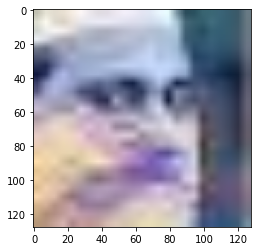


picture=WithMask but model predicted=WithoutMask


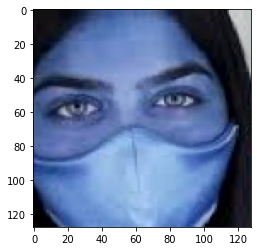


picture=WithMask but model predicted=WithoutMask


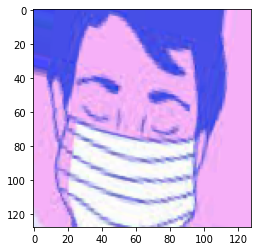


picture=WithMask but model predicted=WithoutMask


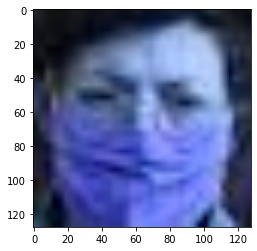


picture=WithoutMask but model predicted=WithMask


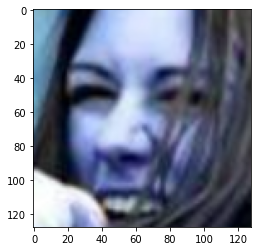


picture=WithoutMask but model predicted=WithMask


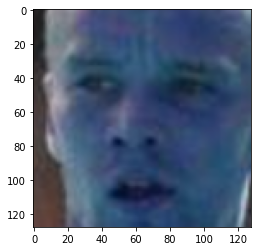


picture=WithoutMask but model predicted=WithMask


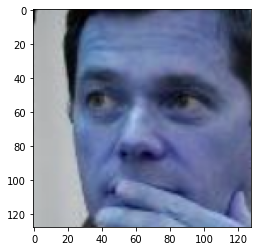


picture=WithoutMask but model predicted=WithMask


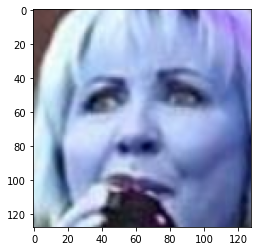


picture=WithoutMask but model predicted=WithMask


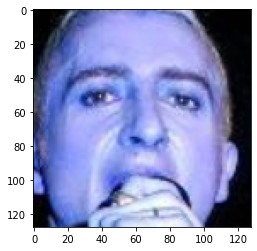


picture=WithoutMask but model predicted=WithMask


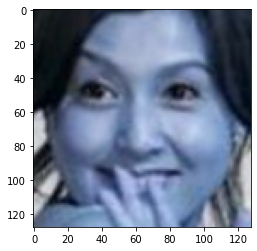


picture=WithoutMask but model predicted=WithMask


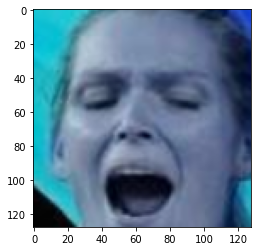


picture=WithoutMask but model predicted=WithMask


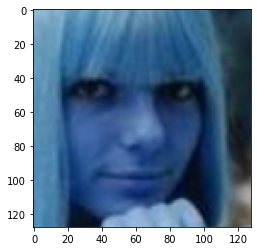


picture=WithoutMask but model predicted=WithMask


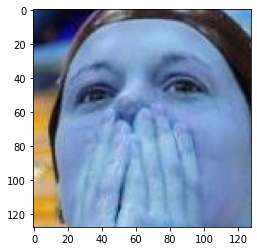


picture=WithoutMask but model predicted=WithMask


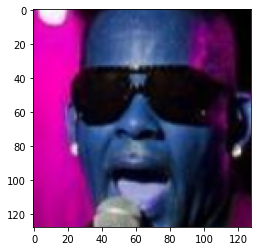


picture=WithoutMask but model predicted=WithMask


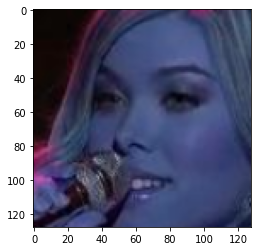


picture=WithoutMask but model predicted=WithMask


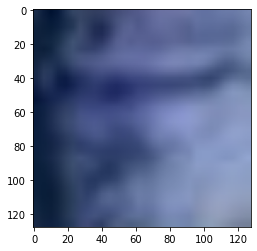


picture=WithoutMask but model predicted=WithMask


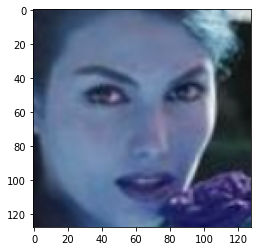


picture=WithoutMask but model predicted=WithMask


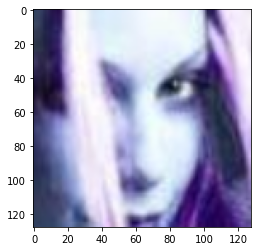


picture=WithoutMask but model predicted=WithMask


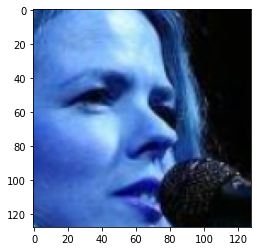


picture=WithoutMask but model predicted=WithMask


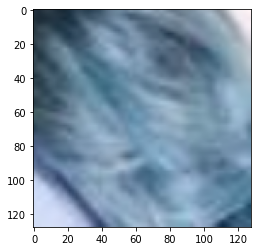


picture=WithoutMask but model predicted=WithMask


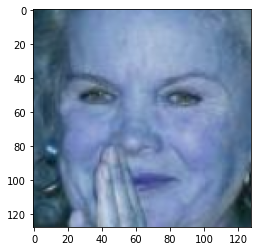


Total comparisons=992 incorrect pred=21 Accuracy%=0.9788306451612904


0.9788306451612904

In [ ]:
test_model(model1)


###Plotting the Model

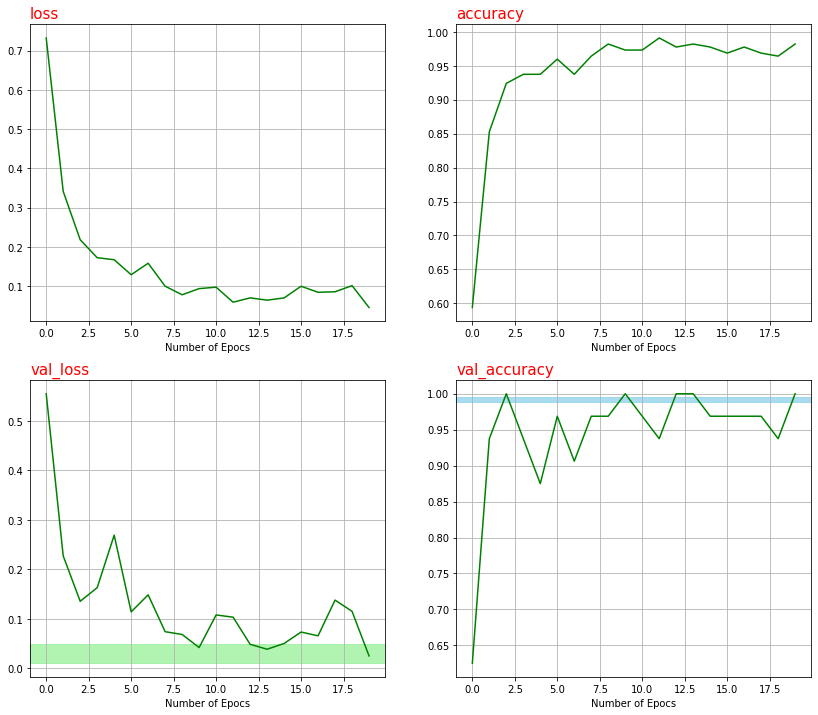

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
for i,value in enumerate(loss_acc_values[0].history):
    ax = axes.flatten()[i]
    layer_num = 0
    for history in loss_acc_values:
        ax.plot(history.history[value],color="g")
        if value=="val_accuracy":
            ax.axhspan(0.988,0.995,color="skyblue",alpha=0.7)
        elif value=="val_loss":
            ax.axhspan(0.05,0.01,color="lightgreen",alpha=0.7)
    ax.set_title(value,size=15, color="r",loc="left")
    ax.set_xlabel("Number of Epocs")
    ax.grid()
plt.show()

In [ ]:
evaluation= model1.evaluate_generator(test)
print('Accuracy on test set:', evaluation[1])
print('Loss on test set:', evaluation[0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Accuracy on test set: 0.9818548560142517
Loss on test set: 0.05364663153886795


Our model performed very well on the training and validation sets with few layers. Where the validation accuracy reachs 0.98, test set comes with 0.98 accuracy and 0.053 loss.

### Residual Convolutional Neural Networks 50
ResNet is one of the usefull models for image recognition tasks. Most noticable feature of this neural network architecture is some direct connections which skip middle layers rather then subsequent layer (it might vary on different ResNet models). In Keras API, there are 6 different ResNet architectures (ResNet50,ResNet101,ResNet152,ResNet50V2,ResNet101V2,ResNet152V2) which we are going to use them with Transfer Learning method. For more information about how to use those pre-build ResNet models in Keras

In [ ]:
ResNet_models={"ResNet50":ResNet50(include_top=False,input_shape=(height, width,3)),"ResNet101":ResNet101(include_top=False, input_shape=(height, width, 3)),
              'ResNet152':ResNet152(include_top=False, input_shape=(height, width, 3)),"ResNet50V2":ResNet50V2(include_top=False, input_shape=(height, width, 3)),
              'ResNet101V2':ResNet101V2(include_top=False, input_shape=(height, width, 3)),'ResNet152V2':ResNet152V2(include_top=False, input_shape=(height, width, 3))}

234553344/234545216 [==============================] - 2s 0us/step


In transfer learning, we will be only training the layers we added after flattening part.



In [ ]:
import keras
start=time.perf_counter()
all_models=[]

initializer = tf.keras.initializers.GlorotNormal()

for model_ in ResNet_models:
    print(model_)
    model_=ResNet_models[model_]
    for layer in model_.layers:
        layer.trainable=False
    
    model2=Sequential()
    model2.add(model_)
    
    model2.add(Flatten())
    model2.add(BatchNormalization(momentum=0.98))
    #Using BatchNormalization can help fast and more accurate results
    model2.add(Dense(128,activation='relu'))
    model2.add(Dropout(0.4))
    model2.add(BatchNormalization(momentum=0.98))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dropout(0.4))
    
    model2.add(Dense(2,activation="sigmoid"))
   

    model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    Checkpoints = ModelCheckpoint('model_mask.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min', save_freq='epoch')


    Earlystop =EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 20,verbose = 1,
                                             restore_best_weights = True)

    callback=[Earlystop,Checkpoints]


    epochs=20
    train_numbers=10000
    valid_numbers=800
    all_models.append(model2.fit_generator(generator=train,
                                           validation_data=valid,
                                           epochs=epochs,
                                           callbacks=callback,
                                           steps_per_epoch=len(train)//32,
                                           validation_steps=len(valid)//32))

stop=time.perf_counter()

print('{:0.4f} mins elapsed'.format((stop-start)/60))



ResNet50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20
7/7 [==============================] - 7s 409ms/step - loss: 0.8312 - accuracy: 0.5421 - val_loss: 0.7532 - val_accuracy: 0.5625
Epoch 2/20
7/7 [==============================] - 2s 229ms/step - loss: 0.5752 - accuracy: 0.7150 - val_loss: 0.8474 - val_accuracy: 0.4062
Epoch 3/20
7/7 [==============================] - 2s 225ms/step - loss: 0.5094 - accuracy: 0.7834 - val_loss: 0.7130 - val_accuracy: 0.4688
Epoch 4/20
7/7 [==============================] - 2s 233ms/step - loss: 0.4858 - accuracy: 0.8165 - val_loss: 0.5603 - val_accuracy: 0.8438
Epoch 5/20
7/7 [==============================] - 2s 231ms/step - loss: 0.4178 - accuracy: 0.8452 - val_loss: 0.5443 - val_accuracy: 0.7188
Epoch 6/20
7/7 [==============================] - 2s 233ms/step - loss: 0.4185 - accuracy: 0.8128 - val_loss: 0.5244 - val_accuracy: 0.9062
Epoch 7/20
7/7 [==============================] - 2s 223ms/step - loss: 0.3340 - accuracy: 0.8645 - val_loss: 0.4944 - val_accuracy: 0.8438
Epoch 8/20
7/7 [====

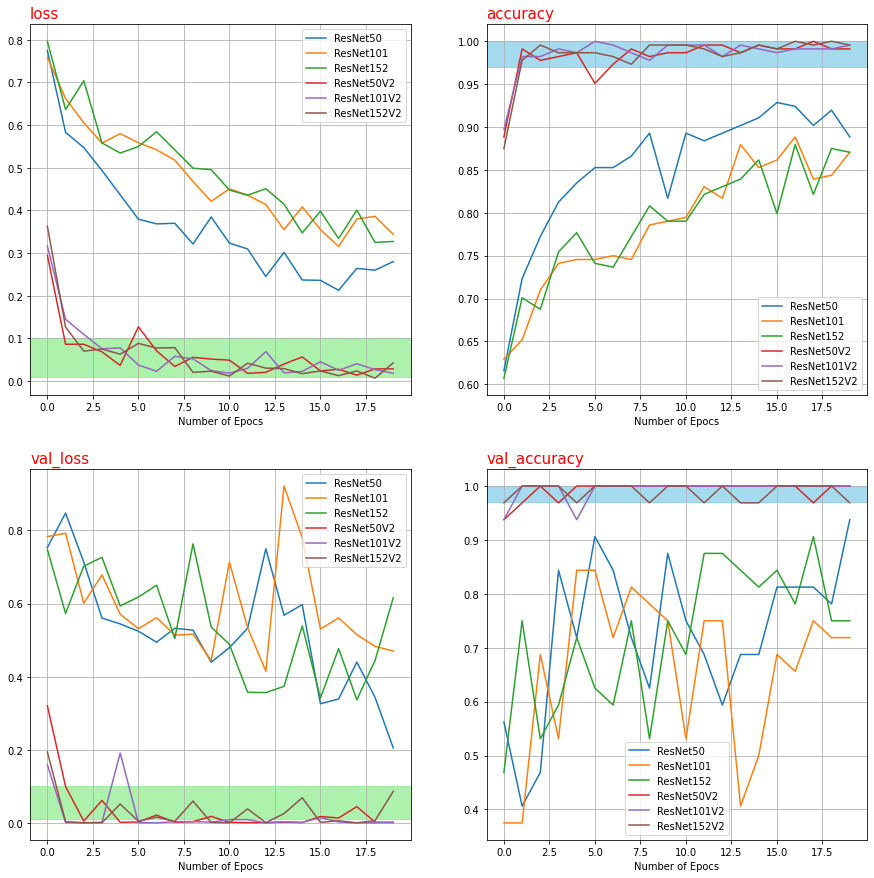

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i,value in enumerate(all_models[0].history):
    ax = axes.flatten()[i]
    lab=0
    for history in all_models:
        label=list(ResNet_models)[lab]
        ax.plot(history.history[value],label=label)
        if value=="accuracy" or value=="val_accuracy":
            ax.axhspan(0.97,1,color="skyblue",alpha=0.2)
        elif value=="loss" or value=="val_loss":
            ax.axhspan(0.1,0.01,color="lightgreen",alpha=0.2)
        lab += 1
    ax.set_title(value,size=15, color="r",loc="left")
    ax.legend()
    ax.set_xlabel("Number of Epocs")
    ax.grid()
plt.show()


Having looked at the results, we can see that ResNet152V2, ResNet101V2 and ResNet50V2 performed pretty good on the validation set as the loss is quite low. Also ResNet50 has lower loss and slightly higher accuracy result than ResNet101 and ResNet152.

### YOLO Model

“YOLO”, refering to “You Only Look Once”, is a family of object detection models introduced by Joseph Redmon with a 2016 publication “You Only Look Once: Unified, Real-Time Object Detection”.
Since then, several newer versions have been released, of which, the first three were released by Joseph Redmon. On June 29, Glenn Jocher released the latest version YOLOv5, claiming significant improvements with respect to its predecessor.

#### Why YOLO?
Using an object detection model such as YOLOv5 is most likely the simplest and most reasonable approach to this problem. This is because we’re limiting the computer vision pipeline to a single step, since object detectors are trained to detect a:

*   Bounding box and a
*   Corresponding label

This is precisely what we’re trying to achieve for this problem. In our case, the bounding boxes will be the detected faces, and the corresponding labels will indicate whether the person is wearing a mask or not.
Alternatively, if we wanted to build our own deep learning model, it would be more complex, since it would have to be 2-fold: we’d need a model to detect faces in an image, and a second model to detect the presence or absence of face mask in the found bounding boxes.

A drawback of doing so, apart from the complexity, is that the inference time would be much slower, especially in images with many faces.

In [ ]:
!git clone https://github.com/rkuo2000/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 3390, done.
remote: Total 3390 (delta 0), reused 0 (delta 0), pack-reused 3390
Receiving objects: 100% (3390/3390), 7.02 MiB | 27.86 MiB/s, done.
Resolving deltas: 100% (2273/2273), done.
/content/yolov5


## Repro [YOLOv5](https://github.com/ultralytics/yolov5)

In [ ]:
!mkdir -p Dataset/FaceMask/Images
!mkdir -p Dataset/FaceMask/Labels

In [ ]:
!cp -rf /content/images/* Dataset/FaceMask/Images

In [ ]:
!mkdir -p Dataset/images Dataset/labels

## Create Dataset

In [ ]:
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [ ]:
FILE_ROOT = "/content/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "Dataset/"
LABELS_ROOT = DATA_ROOT + "FaceMask/Labels"
IMAGES_ROOT = DATA_ROOT + "FaceMask/Images"  

DEST_IMAGES_PATH = "images"
DEST_LABELS_PATH = "labels" 

In [ ]:
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

### Convert annotations (from COCO .xml to YOLO format .txt)

In [ ]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def save_file(img_jpg_file_name, size, img_box):
    save_file_name = LABELS_ROOT + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:

        cls_num = classes.index(box[0])

        new_box = cord_converter(size, box[1:])

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        # print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [ ]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

file name:  maksssksksss339.xml
/content/annotations/maksssksksss339.xml
Dataset/FaceMask/Labels/maksssksksss339.txt
file name:  maksssksksss424.xml
/content/annotations/maksssksksss424.xml
Dataset/FaceMask/Labels/maksssksksss424.txt
file name:  maksssksksss345.xml
/content/annotations/maksssksksss345.xml
Dataset/FaceMask/Labels/maksssksksss345.txt
file name:  maksssksksss467.xml
/content/annotations/maksssksksss467.xml
Dataset/FaceMask/Labels/maksssksksss467.txt
file name:  maksssksksss731.xml
/content/annotations/maksssksksss731.xml
Dataset/FaceMask/Labels/maksssksksss731.txt
file name:  maksssksksss630.xml
/content/annotations/maksssksksss630.xml
Dataset/FaceMask/Labels/maksssksksss630.txt
file name:  maksssksksss718.xml
/content/annotations/maksssksksss718.xml
Dataset/FaceMask/Labels/maksssksksss718.txt
file name:  maksssksksss359.xml
/content/annotations/maksssksksss359.xml
Dataset/FaceMask/Labels/maksssksksss359.txt
file name:  maksssksksss48.xml
/content/annotations/maksssksksss

## split Images dataset

In [ ]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('Dataset/FaceMask/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=7)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=8)

print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 853
train : 682
val   : 85
test  : 86


In [ ]:
def copy_data(file_list, img_labels_root, imgs_source, type):

    root_file = Path(DATA_ROOT + DEST_IMAGES_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    root_file = Path(DATA_ROOT + DEST_LABELS_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    for file in file_list:
        img_name = file.replace('.png', '')
        img_src_file = imgs_source + '/' + img_name + '.png'
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        # print(img_sor_file)
        # print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = DATA_ROOT + DEST_IMAGES_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = DATA_ROOT + DEST_LABELS_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [ ]:
copy_data(train_list, LABELS_ROOT, IMAGES_ROOT, "train")
copy_data(val_list,   LABELS_ROOT, IMAGES_ROOT, "val")
copy_data(test_list,  LABELS_ROOT, IMAGES_ROOT, "test")

Path Dataset/images/train is not exit
Path Dataset/labels/train is not exit
Path Dataset/images/val is not exit
Path Dataset/labels/val is not exit
Path Dataset/images/test is not exit
Path Dataset/labels/test is not exit


In [ ]:
!echo "train: Dataset/images/train" > data/facemask.yaml
!echo "val:   Dataset/images/val" >> data/facemask.yaml
!echo "nc : 3" >> data/facemask.yaml
!echo "names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']" >> data/facemask.yaml

!cat data/facemask.yaml

train: Dataset/images/train
val:   Dataset/images/val
nc : 3
names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']


## Train YOLOv5

In [ ]:
!pip install PyYAML==5.1

     |████████████████████████████████| 276kB 4.4MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=6417acdf32508a4f1abbd9551a4c121fe62483aa1a98665f044839b9d95f7cb3
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install torchvision==0.7.0

     |████████████████████████████████| 5.9MB 4.5MB/s 
     |████████████████████████████████| 748.8MB 18kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
# Train with default Yolov5.weight
!python train.py --img 320 --batch 16 --epochs 50 --data data/facemask.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt
# Train with pretrained weight >>> upload newest file to folder weights
#!python train.py --img 320 --batch 16 --epochs 50 --data data/facemask.yaml --cfg models/yolov5s.yaml --weights weights/pretrained.pt


Using torch 1.6.0 CPU

Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='models/yolov5s.yaml', data='data/facemask.yaml', device='', epochs=50, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[320, 320], local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/exp2', single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-04-06 02:58:13.168982: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.

In [ ]:
# save trained weights for detection
!cp runs/train/exp2/weights/best.pt weights


## Test YOLOv5

### Detect Facemask

In [ ]:
!python detect.py --source Dataset/images/test --img-size 320 --conf 0.4 --weights weights/best.pt 

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=320, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='Dataset/images/test', update=False, view_img=False, weights=['weights/best.pt'])
Using torch 1.6.0 CPU

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients
image 1/86 /content/yolov5/Dataset/images/test/maksssksksss103.png: 256x320 4 With_Masks, Done. (0.145s)
image 2/86 /content/yolov5/Dataset/images/test/maksssksksss126.png: 320x224 2 With_Masks, Done. (0.130s)
image 3/86 /content/yolov5/Dataset/images/test/maksssksksss127.png: 320x224 1 With_Masks, Done. (0.105s)
image 4/86 /content/yolov5/Dataset/images/test/maksssksksss131.png: 224x320 4 With_Masks, 2 Without_Masks, Done. (0.125s)
image 5/86 /content/yolov5/Dataset/images/test/maksssksksss134.png: 192x320 4 With_Masks, 2 Without_Masks, Done. (0.108s)
image 6/86 /content/yolov5/Dataset/images/test/makss

In [ ]:
# display detected images
from IPython.display import Image

<function matplotlib.pyplot.show>

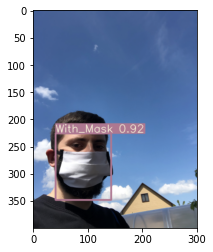

In [ ]:
from glob import glob
import matplotlib.pyplot as plt
testfiles = glob('runs/detect/exp2/*')

img = plt.imread(testfiles[0]) 
plt.imshow(img)    
plt.show

In [ ]:
!python detect.py --source /content/images/maksssksksss103.png --img-size 320 --conf 0.4 --weights weights/best.pt 

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=320, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/images/maksssksksss103.png', update=False, view_img=False, weights=['weights/best.pt'])
Using torch 1.6.0 CPU

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients
image 1/1 /content/images/maksssksksss103.png: 256x320 4 With_Masks, Done. (0.150s)
Results saved to runs/detect/exp4
Done. (0.182s)


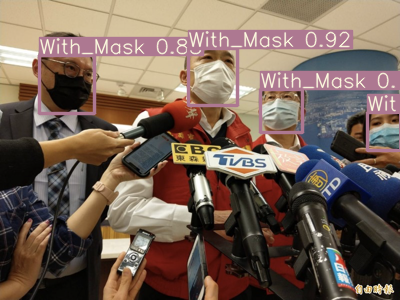

In [ ]:
Image('runs/detect/exp2/maksssksksss103.png')

In [ ]:
!python detect.py --source /content/images/maksssksksss130.png --img-size 320 --conf 0.4 --weights weights/best.pt 

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=320, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/images/maksssksksss130.png', update=False, view_img=False, weights=['weights/best.pt'])
Using torch 1.6.0 CPU

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients
image 1/1 /content/images/maksssksksss130.png: 320x288 4 Without_Masks, Done. (0.145s)
Results saved to runs/detect/exp5
Done. (0.180s)


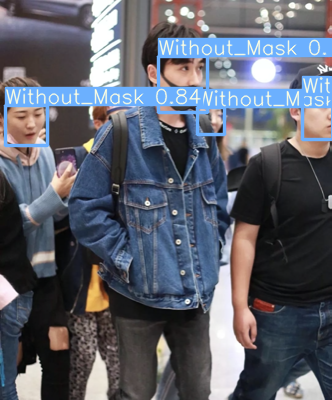

In [ ]:
Image('runs/detect/exp5/maksssksksss130.png')